In [1]:
import numpy as np
import math 
from scipy import optimize
from matplotlib import pyplot as plt
#------------------------------------
#  German Hernández/Código:2171842.
#-----------------------------------

In [2]:
#Calculo de la presión de saturación para el agua con Anotine para dos rangos de temperatura
#Para hacerlo en para muchas temperaturas
def ANTOINE(T):
	T=np.asarray(T)
	i=0
	Ps=[]
	for i in list(range(0,len(T))):
		if 0<=T[i]<57:
			Ctes_A=np.asarray([23.7093,4111,237.7])
			P_s=np.exp(Ctes_A[0]-(Ctes_A[1]/(T[i]+Ctes_A[2])))
			Ps.append(P_s)
		elif 57<=T[i]<135:
			Ctes_A=np.asarray([23.1863,3809.4,226.7])
			P_s=np.exp(Ctes_A[0]-(Ctes_A[1]/(T[i]+Ctes_A[2])))
			Ps.append(P_s)
		else:
			print("Esta fuera del rango establecido")	
	return np.asarray(Ps)
print(ANTOINE([0,134])	)
#(np.asarray(Ps)/101325)*760



[   610.56847544 304117.33189132]


In [3]:
#Calor latente de vaporización del agua (λ), utilizaremos la ecuación PPDS, modificada:
#(λ) kJ/kg
def H_v(T):
    #T= °C
    T=np.asarray(T)
    #Ctes A,B,C,D,E respectivamente
    ctes=np.asarray([27.49401474,-59.14284515,53.99598694,-14.78814244,6.14550793])   
    R=8.314472 #kPa*m^3/kmol*K
    Tc=647.96 #K
    M=18.015 #kg/kmol
    tao=1-((T+273.15)/Tc)
    lamda=(R*Tc/M)*(ctes[0]*tao**(1/3)+ctes[1]*tao**(2/3)+ctes[2]*tao+ctes[3]*tao**2+ctes[4]*tao**6)
    return lamda

H_v([30,69.9523,50])

array([2430.60832922, 2334.04941372, 2382.86720169])

In [4]:
#Entalpía de Saturación kJ/kg Aire seco
def Hs(P,T):
    P=np.asarray(P)
    P_s=ANTOINE(T)
    Y_s=(18.015/28.970)*(P_s/(P-P_s))#Humedad absoluta de saturación kg vap agua/kg Aire seco
    H_s=(1.0035+1.8723*Y_s)*T+(2501.4*Y_s)
    return H_s
Hs([334,335,340],[30,40,50])

array([-1696.28089901, -1638.18608493, -1609.28048142])

In [5]:

#Algoritmo para determinar Temperatura con la ec de Antoine
#P_s = P->Tmax
#P_s = PA->Troc
def Temp(P):
    #P [=] Pa
    #T [=] °C
    P=np.asarray(P)
    T=np.zeros(len(P))    
    Ctes_A1=np.asarray([23.7093,4111,237.7])
    Ctes_A2=np.asarray([23.1863,3809.4,226.7])    
    T1=((Ctes_A1[1]/(Ctes_A1[0]-np.log(P)))-Ctes_A1[2]) 
    T2=((Ctes_A2[1]/(Ctes_A2[0]-np.log(P)))-Ctes_A2[2])   
    i=0
    for i in list(range(0,len(P))):
    	if 0<=T1[i]<57:
    		T[i]=T1[i]
    	elif 57<=T2[i]<135:
    		T[i]=T2[i]             
    	else:
    		#print("Esta fuera del rango establecido")	
    		T[i]=None	        
    return T
    
print(Temp([610.6, 304117.3]))

[7.09603256e-04 1.33999996e+02]


In [6]:
#Realiza todos los calculos para humedad absoluta en un rango de humedades relativas y evaluando a cada temperatura hasta la final
#Solo se puede evaluar de a un dato en formato de lista []
def Y_p(P,HR):
    P=(np.asarray(P)/760)*101325
    Tmax=Temp(P)
    Tf=np.floor(Tmax)-1
    #print(Tf)
    phi=np.asarray([1])
    T=np.asarray([0])
    P_s=ANTOINE(T)
    Yp=(18.015/28.97)*((phi*P_s)/(P-phi*P_s))
    v_T=[]
    v_yp=[]
    while Yp<=0.120 and T<=Tf:
        T=T+1
        #print(T)
        #phi=np.asarray([0,0.1,0.2,0.3,0.4,0.5,0.6,.7,.8,.9,1])
        phi=HR
        k=0
        
        for k in list(range(0,len(phi))):
            P_s=ANTOINE(T)
            P_s=np.asarray(P_s) #Conversión a Pa porque antoine trabaja en Pa
            Yp=(18.015/28.97)*((phi[k]*P_s)/(P-phi[k]*P_s))  
            #print(Yp)
            k=k+1
        v_yp.append(Yp)  
        v_T.append(T)
    return np.asarray(v_yp),np.asarray(v_T)


#Función para el calculo de Temperatura de saturación adiabatica pero con las restricciones
#Solo se puede evaluar de a un dato en formato de lista []
def T_SA2(T,phi,P):
    P=np.asarray(P)
    phi=np.asarray(phi)
    T=np.asarray(T)
    Ma=18.015 
    Mb=28.97
    P=(P/760)*101.325
    Pvapor=ANTOINE(T)
    Pavor=Pvapor[np.where(Pvapor>610.56847544)]
    Pavor=Pvapor[np.where(Pvapor<304117.33189132)]
    Pa = np.asarray(Pvapor)*phi/1000 #Pa->kPa
    Yp=(18.015 / 28.97) * (Pa / (P - Pa))
    Ch=1.0035 + 1.8723 * Yp
    Tsa=T 
    tol=1e-4
    er=1
    k=0
    while np.any(er>=tol):
        lamda_sa=H_v(Tsa)
        Ysa=Yp + (T - Tsa) * Ch / lamda_sa 
        Ps=P * (Ysa / (Ysa + (18.015 / 28.97)))
        if (610.56847544/1000)<Ps<(304117.33189132/1000):
        #if np.all(Ps>(610.56847544/1000)) or np.all(Ps<(304117.33189132/1000)):    
            Tsac=Temp(Ps*1000) #Esta funcion en Pa
            er=abs(Tsa-Tsac)
            Tsa=Tsac
            k=k+1
        else:
            Tsa=np.asarray([None])
            break
    return Tsa
#print(T_SA2([65],[0.55],[685]))
#print(Y_p([760],[0.1]))

## Carta psicometrica Y' vs T usando phi ##

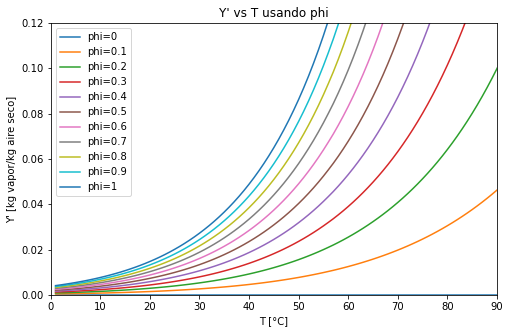

In [36]:
#Función para ordenar los datos de temperatura y humedad absoluta Y'
def TG_HA(P):
    phi=np.asarray([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    Tg=[]
    Ha=[]
    for k in list(range(0,11)):
        TG=Y_p(P,[phi[k]])[1]  
        HA=Y_p(P,[phi[k]])[0]  
        Tg.append(TG)
        Ha.append(HA)
    return np.asarray(Tg),np.asarray(Ha)    

#Grafico de Yp contra TG 
def G_HPHI(P):
    Yp=[TG_HA(P)[1][0],TG_HA(P)[1][1],TG_HA(P)[1][2],TG_HA(P)[1][3],TG_HA(P)[1][4],TG_HA(P)[1][5],TG_HA(P)[1][6],TG_HA(P)[1][7],TG_HA(P)[1][8],TG_HA(P)[1][9],TG_HA(P)[1][10]]
    TG=[TG_HA(P)[0][0],TG_HA(P)[0][1],TG_HA(P)[0][2],TG_HA(P)[0][3],TG_HA(P)[0][4],TG_HA(P)[0][5],TG_HA(P)[0][6],TG_HA(P)[0][7],TG_HA(P)[0][8],TG_HA(P)[0][9],TG_HA(P)[0][10]]
    i=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    plt.figure(figsize=(8,5))
    for k in list(range(0,len(Yp))):
        plt.plot(TG[k],Yp[k],label="phi="+str(i[k]))
    plt.title("Y' vs T usando phi")
    plt.legend(loc="best")
    plt.xlabel("T [°C]")
    plt.ylabel("Y' [kg vapor/kg aire seco]")
    plt.xlim(0,90)
    plt.ylim(0,0.12)
    return plt.show()
G_HPHI([760])
#TG_HA([760])[0][0]

## Carta psicometrica Y vs T usando phi ##

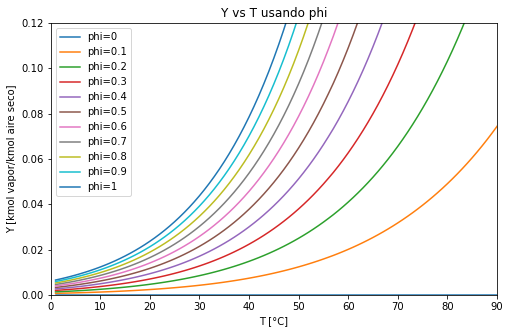

In [37]:
def G_HPHI2(P):
    Yp=[TG_HA(P)[1][0],TG_HA(P)[1][1],TG_HA(P)[1][2],TG_HA(P)[1][3],TG_HA(P)[1][4],TG_HA(P)[1][5],TG_HA(P)[1][6],TG_HA(P)[1][7],TG_HA(P)[1][8],TG_HA(P)[1][9],TG_HA(P)[1][10]]
    Yp=np.asarray(Yp)/((18.015 / 28.97))
    TG=[TG_HA(P)[0][0],TG_HA(P)[0][1],TG_HA(P)[0][2],TG_HA(P)[0][3],TG_HA(P)[0][4],TG_HA(P)[0][5],TG_HA(P)[0][6],TG_HA(P)[0][7],TG_HA(P)[0][8],TG_HA(P)[0][9],TG_HA(P)[0][10]]
    i=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    plt.figure(figsize=(8,5))
    for k in list(range(0,len(Yp))):
        plt.plot(TG[k],Yp[k],label="phi="+str(i[k]))
    plt.title("Y vs T usando phi")
    plt.legend(loc="best")
    plt.xlabel("T [°C]")
    plt.ylabel("Y [kmol vapor/kmol aire seco]")
    plt.xlim(0,90)
    plt.ylim(0,0.12)
    return plt.show()
G_HPHI2([760])

## Y' vs T usando Hp ##

In [9]:
#Solo se puede evaluar de a un dato en formato de lista []
def Y_hp(P,H_P):
    P=(np.asarray(P)/760)*101325
    Tmax=Temp(P)
    Tf=np.floor(Tmax)-1
    #print(Tf)
    hp=np.asarray([1])
    T=np.asarray([0])
    P_s=ANTOINE(T)
    HR=hp*((P)/(P+(P_s*(hp-1))))
    Yp=(18.015/28.97)*((HR*P_s)/(P-HR*P_s))
    v_T=[]
    v_yp=[]
    while Yp<=0.120 and T<=Tf:
        T=T+1
        #print(T)
        #phi=np.asarray([0,0.1,0.2,0.3,0.4,0.5,0.6,.7,.8,.9,1])
        hp=H_P
        k=0
        
        for k in list(range(0,len(hp))):
            P_s=ANTOINE(T)
            P_s=np.asarray(P_s) #Conversión a Pa porque antoine trabaja en Pa
            phi=hp[k]*((P)/(P+(P_s*(hp[k]-1))))
            Yp=(18.015/28.97)*((phi*P_s)/(P-phi*P_s))  
            #print(Yp)
            k=k+1
        v_yp.append(Yp)  
        v_T.append(T)
    return np.asarray(v_yp),np.asarray(v_T)
#Y_hp([760],[0.2])[0]

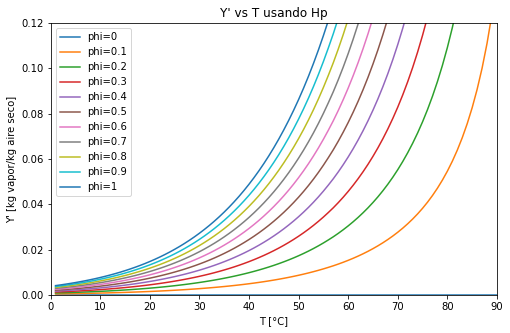

In [38]:
#Función para ordenar los datos de temperatura y humedad absoluta Y' a partir de Hp
def TG_Hap(P):
    hp=np.asarray([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
    Tg=[]
    Ha=[]
    for k in list(range(0,len(hp))):
        TG=Y_hp(P,[hp[k]])[1]  
        HA=Y_hp(P,[hp[k]])[0]  
        Tg.append(TG)
        Ha.append(HA)
    return np.asarray(Tg),np.asarray(Ha)

def G_HPHI3(P):
    Yp=[TG_Hap(P)[1][0],TG_Hap(P)[1][1],TG_Hap(P)[1][2],TG_Hap(P)[1][3],TG_Hap(P)[1][4],TG_Hap(P)[1][5],TG_Hap(P)[1][6],TG_Hap(P)[1][7],TG_Hap(P)[1][8],TG_Hap(P)[1][9],TG_Hap(P)[1][10]]
    TG=[TG_Hap(P)[0][0],TG_Hap(P)[0][1],TG_Hap(P)[0][2],TG_Hap(P)[0][3],TG_Hap(P)[0][4],TG_Hap(P)[0][5],TG_Hap(P)[0][6],TG_Hap(P)[0][7],TG_Hap(P)[0][8],TG_Hap(P)[0][9],TG_Hap(P)[0][10]]
    i=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    plt.figure(figsize=(8,5))
    for k in list(range(0,len(Yp))):
        plt.plot(TG[k],Yp[k],label="phi="+str(i[k]))
    plt.title("Y' vs T usando Hp")
    plt.legend(loc="best")
    plt.xlabel("T [°C]")
    plt.ylabel("Y' [kg vapor/kg aire seco]")
    plt.xlim(0,90)
    plt.ylim(0,0.12)
    return plt.show()
G_HPHI3([760])
#TG_Hap([760])[1][1]


## Y vs T usando Hp ##

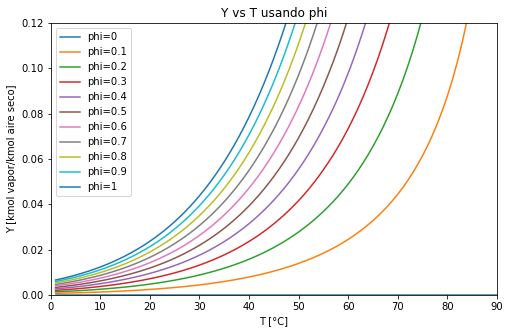

In [39]:
def G_HPHI4(P):
    Yp=[TG_Hap(P)[1][0],TG_Hap(P)[1][1],TG_Hap(P)[1][2],TG_Hap(P)[1][3],TG_Hap(P)[1][4],TG_Hap(P)[1][5],TG_Hap(P)[1][6],TG_Hap(P)[1][7],TG_Hap(P)[1][8],TG_Hap(P)[1][9],TG_Hap(P)[1][10]]
    Yp=np.asarray(Yp)/((18.015 / 28.97))
    TG=[TG_Hap(P)[0][0],TG_Hap(P)[0][1],TG_Hap(P)[0][2],TG_Hap(P)[0][3],TG_Hap(P)[0][4],TG_Hap(P)[0][5],TG_Hap(P)[0][6],TG_Hap(P)[0][7],TG_Hap(P)[0][8],TG_Hap(P)[0][9],TG_Hap(P)[0][10]]
    i=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    plt.figure(figsize=(8,5))
    for k in list(range(0,len(Yp))):
        plt.plot(TG[k],Yp[k],label="phi="+str(i[k]))
    plt.title("Y vs T usando phi")
    plt.legend(loc="best")
    plt.xlabel("T [°C]")
    plt.ylabel("Y [kmol vapor/kmol aire seco]")
    plt.xlim(0,90)
    plt.ylim(0,0.12)
    return plt.show()
G_HPHI4([760])

In [12]:
#Funcion para evaluar la temperatura de sat adiabatica a las temperaturas del algortimo Y'
#Solo se puede variar de a un dato en formato de lista []
def Tsa_ev(P,HR):
    TG=Y_p(P,HR)[1]
    print(TG)
    TSSA=[]
    for j in list(range(0,len(TG))):
        Tsa=T_SA2(TG[j],HR,P)
        TSSA.append(Tsa)
    return TSSA    
#Tsa_ev([760],[0.1])

In [13]:
#Se intentaron trazar las lineas de saturación adiabatica 

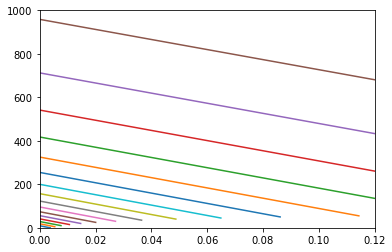

In [14]:
def TGm(P):
    P=(np.asarray(P)/760)*101325
    Cpb=1.0035
    Tbh=np.arange(0,100,5)
    Yp=np.zeros(len(Tbh))
    lmda=H_v(Tbh)
    phi=np.asarray([1])
    P_s=ANTOINE(Tbh)
    Yps=(18.015/28.97)*((phi*P_s)/(P-phi*P_s))
    TGmax=Tbh+((lmda*Yps)/Cpb)
    return Yps,Yp,Tbh,TGmax
#TGm([760])
RTAS=TGm([760])
y=[RTAS[2],RTAS[3]]
x=[RTAS[0],RTAS[1]]
plt.xlim(0,0.120)
plt.ylim(0,1000)
plt.plot(x,y)
plt.show()
